In [1]:
import os
import h5py
import numpy as np

data_dir = 'data'
if not os.path.exists(os.path.join(data_dir, 'random.hdf5')):
    print("Create random data for array exercise")
    with h5py.File(os.path.join(data_dir, 'random.hdf5')) as f:
        dset = f.create_dataset('/x', shape=(1000000000,), dtype='f4')
        for i in range(0, 1000000000, 1000000):
            dset[i: i + 1000000] = np.random.exponential(size=1000000)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

**Related Documentation**

* [Documentation](http://dask.readthedocs.io/en/latest/array.html)
* [API reference](http://dask.readthedocs.io/en/latest/array-api.html)

In [2]:
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

In [3]:
%%time
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

999984705.125
CPU times: user 552 ms, sys: 808 ms, total: 1.36 s
Wall time: 11.2 s


In [4]:
%%time
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.mean())

total = sum(sums)
print(total)

999.9847071766853
CPU times: user 552 ms, sys: 480 ms, total: 1.03 s
Wall time: 1.03 s


In [5]:
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))

In [6]:
%%time
result = x.sum()
print(result.compute())

999984700.0
CPU times: user 1.08 s, sys: 704 ms, total: 1.78 s
Wall time: 1.29 s


In [7]:
%%time
result = x.mean()
print(result.compute())

0.9999847
CPU times: user 2.5 s, sys: 804 ms, total: 3.3 s
Wall time: 1.72 s


Performance and Parallelism
-------------------------------

<img src="dask-tutorial/images/fail-case.gif" width="40%" align="right">

In our first examples we used `for` loops to walk through the array one block at a time.  For simple operations like `sum` this is optimal.  However for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

Dask.array translates your array operations into a graph of inter-related tasks with data dependencies between them.  Dask then executes this graph in parallel with multiple threads.  We'll discuss more about this in the next section.

In [8]:
x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations
x.nbytes / 1e9

3.2

In [9]:
%%time
print(y.compute())

[ 9.99967054  9.99905211  9.99974791 10.00018607 10.00042476 10.00074782
 10.00033308  9.99972634 10.00025575 10.00038209 10.00036975  9.99948446
  9.99971708  9.9995597   9.99962465 10.00004452  9.99976248 10.00038639
 10.00023375 10.00044562 10.00031191 10.00023506 10.00002922  9.99931547
  9.99838513  9.99913871  9.99907848 10.00090273  9.99971161 10.00045218
 10.00152697 10.00121579 10.0003026   9.99934908  9.99943918 10.00047685
 10.00015247 10.00091972  9.99898908  9.99965099 10.00056881  9.99986674
 10.00031944  9.99927967  9.99938684 10.00004106 10.00016632  9.99917503
  9.99995296  9.9999206   9.99887303 10.00034182  9.99954451 10.00039312
 10.00038275  9.99896873  9.99978978 10.00024422 10.00031589 10.00171131
 10.00038019  9.99821954  9.9985069  10.00002053 10.00119961  9.99929593
  9.99953909 10.00000854  9.9989703  10.00024324 10.00019765  9.99994626
 10.00011254 10.00027038 10.00059506 10.00000734 10.00120143 10.00035257
 10.00060823  9.99995339 10.00073674 10.000884   10

In [10]:
%%time
print(np.random.normal(10, 0.1, size=(20000, 20000)).mean(axis=0)[::100])

[ 9.99992101  9.99995355  9.99863448  9.99935485 10.00051379 10.00045605
  9.99987057 10.00060351  9.99973078 10.00079629 10.00001582  9.99985905
  9.99994277 10.00118533  9.99922769 10.00042235  9.99990714  9.99932664
 10.00073849 10.00025404  9.99938799  9.99967526 10.0003377   9.99962003
 10.00084368 10.00146061  9.9997595  10.00065762 10.00085184 10.00041013
 10.00074434  9.99936935  9.99940931  9.99933346  9.99934045  9.99921446
 10.00028667 10.00054197  9.99846103 10.00035048 10.0006521  10.00063074
 10.00013497  9.99874622 10.00042269 10.00022976  9.99896472  9.99976258
 10.00011629  9.99928062  9.99961401 10.00000222  9.99950321 10.00030165
 10.00006097 10.00066955  9.99963135  9.99952145  9.99964377  9.99969331
 10.00114524  9.99927609  9.99863973 10.00157853  9.99994967 10.00048853
 10.00045557  9.99898811 10.00087729 10.00002587  9.99980801  9.99909841
  9.99945587 10.00017347 10.00018746  9.99899966 10.00024906 10.00035797
 10.00067879 10.0007729   9.99951279  9.99961461  9

**NumPy: Needs gigabytes of memory**

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

**Dask Array: 4s, Needs megabytes of memory**

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

In [21]:
import glob
data_dir = 'data'
filenames = sorted(glob.glob(os.path.join(data_dir, 'weather-small', '*.hdf5')))

if not os.path.exists(os.path.join(data_dir, 'weather-big')):
    os.mkdir(os.path.join(data_dir, 'weather-big'))

from skimage.transform import resize
import h5py

print('Exploding weather data')
for fn in filenames:
    print(fn)
    with h5py.File(fn, mode='r') as f:
        x = f['/t2m'][:]

    y = resize(x, (x.shape[0] * 32, x.shape[1] * 32), mode='constant')

    out_fn = os.path.join(data_dir, 'weather-big', os.path.split(fn)[-1])

    try:
        with h5py.File(out_fn) as f:
            f.create_dataset('/t2m', data=y, chunks=(500, 500))
    except:
        pass

Exploding weather data
data/weather-small/2014-01-01.hdf5
data/weather-small/2014-01-02.hdf5
data/weather-small/2014-01-03.hdf5
data/weather-small/2014-01-04.hdf5
data/weather-small/2014-01-05.hdf5
data/weather-small/2014-01-06.hdf5
data/weather-small/2014-01-07.hdf5
data/weather-small/2014-01-08.hdf5
data/weather-small/2014-01-09.hdf5
data/weather-small/2014-01-10.hdf5
data/weather-small/2014-01-11.hdf5
data/weather-small/2014-01-12.hdf5
data/weather-small/2014-01-13.hdf5
data/weather-small/2014-01-14.hdf5
data/weather-small/2014-01-15.hdf5
data/weather-small/2014-01-16.hdf5
data/weather-small/2014-01-17.hdf5
data/weather-small/2014-01-18.hdf5
data/weather-small/2014-01-19.hdf5
data/weather-small/2014-01-20.hdf5
data/weather-small/2014-01-21.hdf5
data/weather-small/2014-01-22.hdf5
data/weather-small/2014-01-23.hdf5
data/weather-small/2014-01-24.hdf5
data/weather-small/2014-01-25.hdf5
data/weather-small/2014-01-26.hdf5
data/weather-small/2014-01-27.hdf5
data/weather-small/2014-01-28.hd

In [22]:
filenames = sorted(glob.glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [23]:
dsets[0][:5, :5]

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

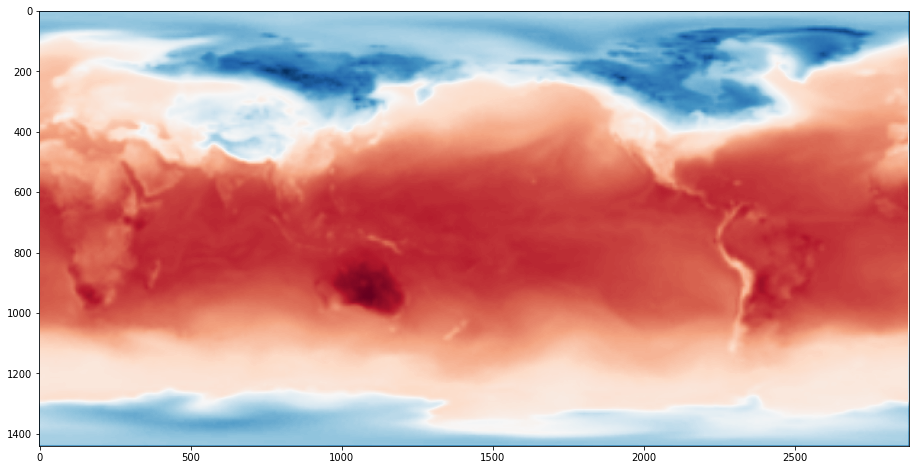

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r')
plt.show()

In [27]:
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize

In [28]:
x = da.stack(arrays, axis=0)
x

dask.array<stack, shape=(31, 5760, 11520), dtype=float64, chunksize=(1, 500, 500)>

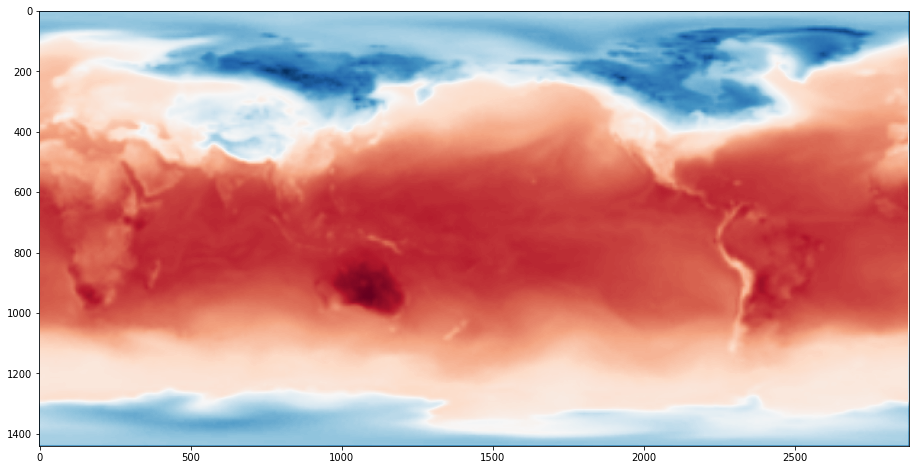

In [29]:
fig = plt.figure(figsize=(16, 8))
plt.imshow(x[0][::4, ::4], cmap='RdBu_r')
plt.show()

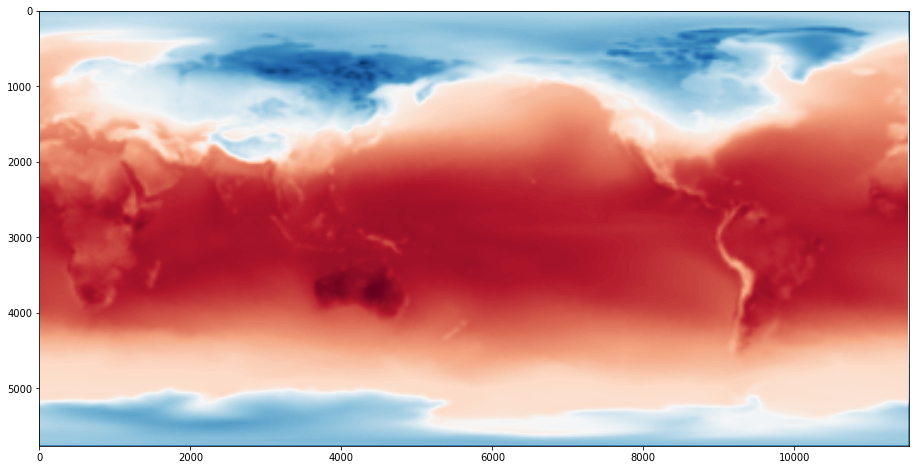

In [30]:
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')
plt.show()

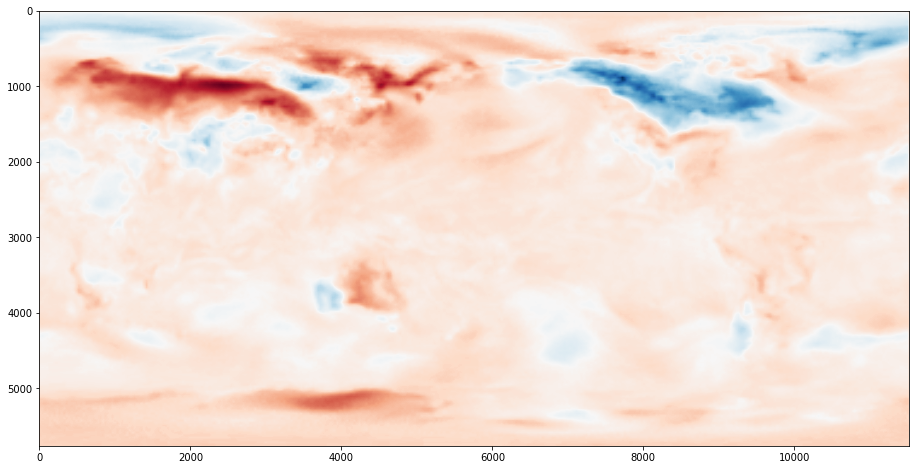

In [31]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')
plt.show()

In [32]:
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# build the matrix of distances
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# the lj function is evaluated over the upper triangle
# after removing distances near zero
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [33]:
cluster = make_cluster(int(7e3), radius=500)

In [35]:
%time potential(cluster)

CPU times: user 2.69 s, sys: 2.7 s, total: 5.4 s
Wall time: 5.43 s


-0.21282893668845293

In [38]:
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

In [36]:
from os import cpu_count

dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

In [40]:
e = potential_dask(dcluster)
%time e.compute()

/usr/local/lib/python3.5/dist-packages/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/usr/local/lib/python3.5/dist-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


CPU times: user 4.85 s, sys: 1.01 s, total: 5.86 s
Wall time: 1.71 s


-0.21282893668845307